## Quantifying Influence of The Beatle and The Rolling Stones
Using data acquired from the MusicBrainz database, cleaned and aggregated in [this](_maxrose_dsFinal_Acquire_Clean_Merge.ipynb) notebook, I have developed a set of observations around the songs recorded and released by two artists - The Beatles and The Rolling Stones. I chose these two artists for the enduring popularity and the time-tested legacy of their recorded output. The response by which I will measure their influence is measured by other artists recorded use of their songs, "cover versions" or "covers" in the vernacular.<br><br>

I have compiled data from the source artists representing all songs recorded, the number of times the song was released by the artist, the number of countries for each release and the average rating for the song or release as reported by MusicBrainz.<br>
I also acquired the lyrics for as many of the original songs as I could using Beautiful Soup to scrape the lyrics from (lyrics.wikia.com)[http://lyrics.wikia.com). I was able to acquire lyrical content for 96.5% of the original songs to apply sentiment analysis using TextBlob. The sentiment polarity was applied separately to both the song title and the lyrics themselves to create features to augment the song/release data. As I am able to show below, the **lyric sentiment** is one of the more predictive measurements, second only to the year a song was released.<br><br>

With each row in my dataset - songname, artist, etc., I then merged the number of times the song was covered ("times_covered") and the number of artists covering the song ("artist_cnt"). I then created a binary response ("is_covered") as a simpler indicator that the song was used over the number of times used. This proved to be more predictable than the number of times covered. Also included is the average rating of the cover versions per song though I suspect the data is not so useful.

In [1]:
### Import as many items as possible to have available.
### Import data from CSV

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import MultinomialNB

data = pd.read_csv('data/Influence_clean.csv', header=0,encoding= 'utf-8',  delimiter='|')
data['minreleasedate'] = pd.to_datetime(pd.Series(data.minreleasedate))
data['times_covered'].fillna(0, inplace=True)
data['artistid'] = data.artist.map({'The Beatles':0, 'The Rolling Stones':1})

In [2]:
data['artist'] = data.artist.astype('category')
data['songname'] = data.songname.astype('category')
# Add column for year of release for simpler grouping.
data['year'] = data['minreleasedate'].apply(lambda x: x.year)

# Make binary response - song has been covered or not. Far better accuracy over "times covered".
data['is_covered'] = data.times_covered.map(lambda x: 1 if x > 0 else 0)


### Check coverage of lyrics for the original songs.
**96.6%** have lyrics (and lyric sentiment polarity score) in the dataset. **Lyric sentiment** is a valuable predictor.

In [19]:
data[(data.is_cover == 0) & (data.lyrics.isnull())].workid.count().astype(float)/data[(data.is_cover == 0)].workid.count()

0.033457249070631967

### Create base set of features for fitting to models

In [50]:
feature_cols = [ 'year','num_releases','lyric_sent','title_sent', 'countries', 'avg_rating']
X= data[data.is_cover == 0][feature_cols]
y = data[data.is_cover == 0].is_covered
y_regress = data[data.is_cover == 0].times_covered
print X.shape
print y.shape
print y_regress.shape

(269, 6)
(269,)
(269,)


### Build model with Random Forest Classifier (RFC)

In [25]:
feature_range = range(1, len(feature_cols)+1)

# list to store the accuracy score for each value of max_features
Acc_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfclass = RandomForestClassifier(n_estimators=500, max_features=feature, random_state=50)
    acc_val_scores = cross_val_score(rfclass, X, y, cv=10, scoring='accuracy')
    Acc_scores.append(acc_val_scores.mean())

### I have chosen 6 features for the RFC model after running a looped evaluation of the maximum features for the model using cross validation.

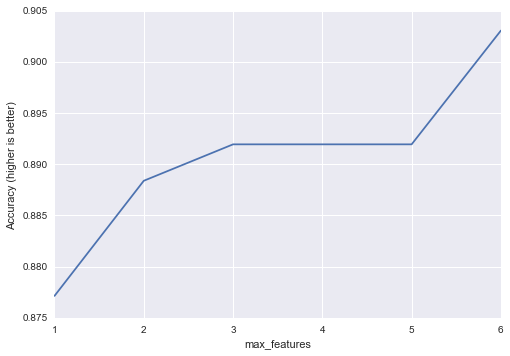

In [26]:
# plot max_features (x-axis) versus Accuracy score (y-axis)
plt.plot(feature_range, Acc_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy (higher is better)')

In [46]:
rfclass = RandomForestClassifier(n_estimators=175,  max_features=6,oob_score=True, random_state=50)
rfclass.fit(X, y)
print rfclass.oob_score_
print cross_val_score(rfclass, X, y, cv=10, scoring='accuracy').mean()

0.921933085502
0.903347578348


### At *92%* and *90%* respectively, both the out of bag and cross-validation scores are quite positive for the Random Forest Classifier. 


<br>
### Testing Random Forest Regressor to predict "times_covered"

In [140]:
from sklearn.feature_selection import SelectFromModel
rfreg = RandomForestRegressor(n_estimators=100, max_features=6, random_state=111)
rfreg.fit(X,y_regress)
sfm = SelectFromModel(rfreg, threshold='mean', prefit=True)
X_important = sfm.transform(X)
print(X_important.shape[0],X_important.shape[1])

(269, 4)


In [141]:
rfreg = RandomForestRegressor(n_estimators=100, max_features=3, random_state=111)
scores = cross_val_score(rfreg, X_important, y_regress, cv=10, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

28.102616089590231

### I conclude that I can predict whether a song will be covered far more accurately than how many times it will be covered.<br>
**90%** vs. **28%**
<br><br>


### Test with DecisionTreeClassifier
While seeking a less opaque model than the Random Forest, I tried the DecisionTreeClassifier, to take advantage of the very nice method for ranking the importance of the features.

In [77]:
treeclf = DecisionTreeClassifier(max_depth = 15, random_state=123)
treeclf.fit(X, y)
scores = cross_val_score(treeclf, X, y, cv=10).mean()
np.mean(np.sqrt(scores))

0.94857603796242917

### As shown in the bar chart below, year and lyric sentiment are better predictors of whether or not a song is covered.

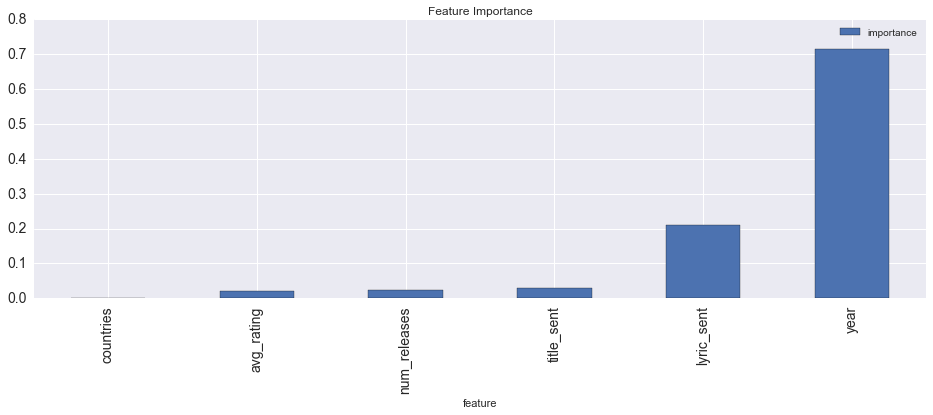

In [78]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_}).sort_values('importance').plot(kind='bar',x='feature',figsize=(16,5),fontsize='14',title="Feature Importance")

## Let's review some simples metrics comparing the two bands.<br><br>

## A quick measure of songs covered by release year for both artists.
<br> While The Beatle disbanded by 1970, The Stones continue to this day. However, their early work appears far more influential, with the greatest body of influence more or less paralelling that of The more covered Beatles. Let's put a number on that, shall we?

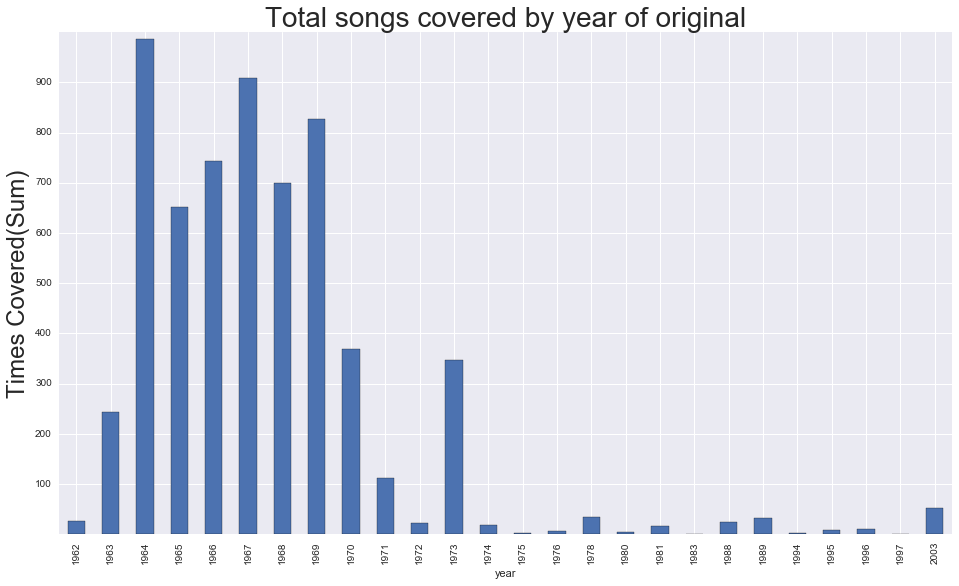

In [154]:
yticks = np.arange(100, 1000, 100)
data[data.times_covered > 0].groupby('year').times_covered.sum().plot(kind='bar',x='year',y='times_covered',figsize=(16,9))
plt.yticks(yticks)
plt.title('Total songs covered by year of original',size =28)
plt.ylabel('Times Covered(Sum)', size = 24)


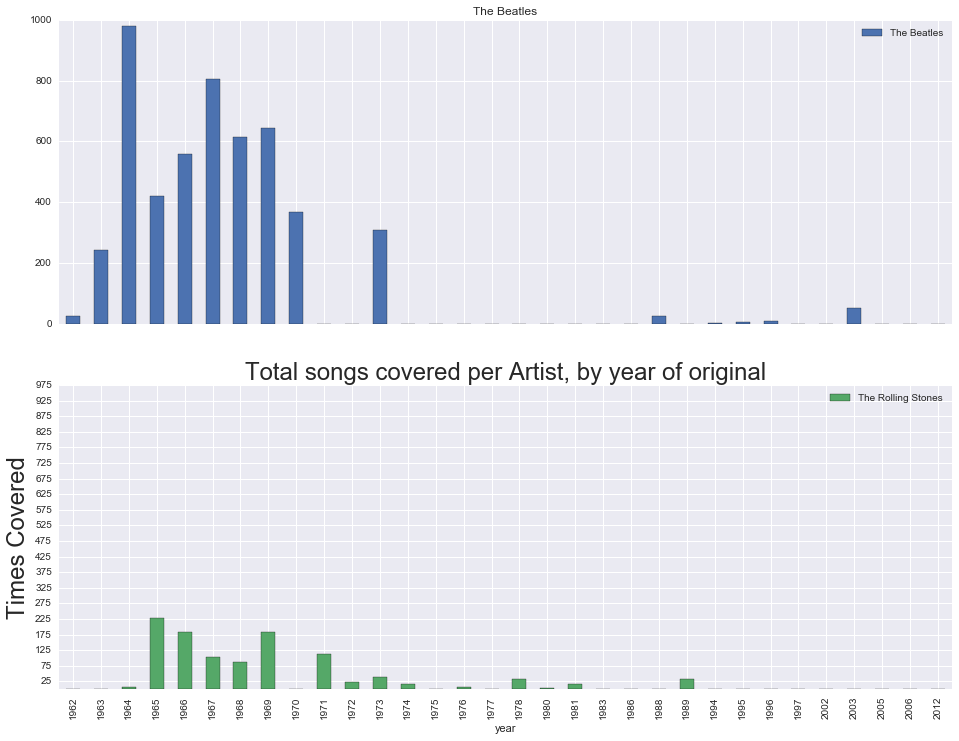

In [155]:
### First plot is The Beatles, second The Rolling Stones. Sum of times_covered by year of oriiginal relase of the song.
bar = data.sort_values(by='year').groupby(['year', 'artist'])['times_covered'].sum().unstack('artist')
yticks = np.arange(25, 1000, 50)
bar.plot(kind='bar', stacked=True,figsize=(16,12),subplots='True')
plt.yticks(yticks)
plt.title('Total songs covered per Artist, by year of original',size =24)
plt.ylabel('Times Covered', size = 24)

### It appears that a pretty large percentage of the artist's catalogs have been covered at least once.<br>
**90%** of Beatles songs have been covered, **66%** of Rolling Stones. By this measure, The Liverpuddlians may be deemed "more influential".

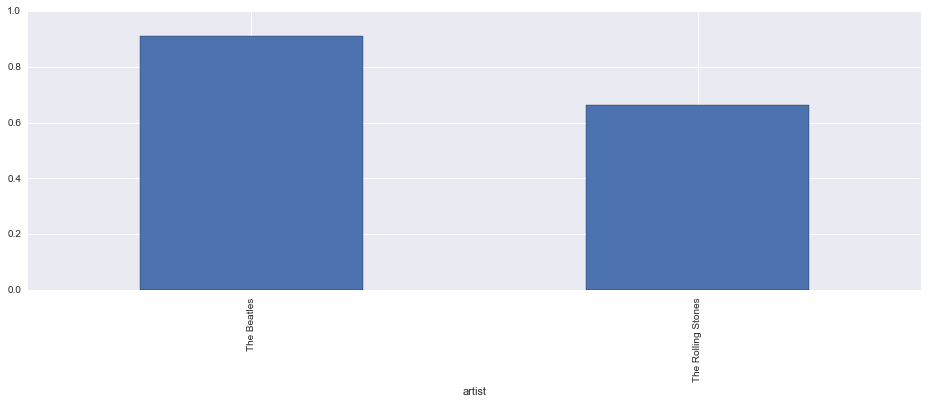

In [153]:
# Throw out covers recorded by each band and see what percentage of their catalogs have been covered.
inf = data[(data.is_cover == 0) & (data.is_covered == 1)].groupby('artist').workid.count()/data[(data.is_cover == 0)].groupby('artist').workid.count()
inf.plot(kind='bar', figsize=(16,5))

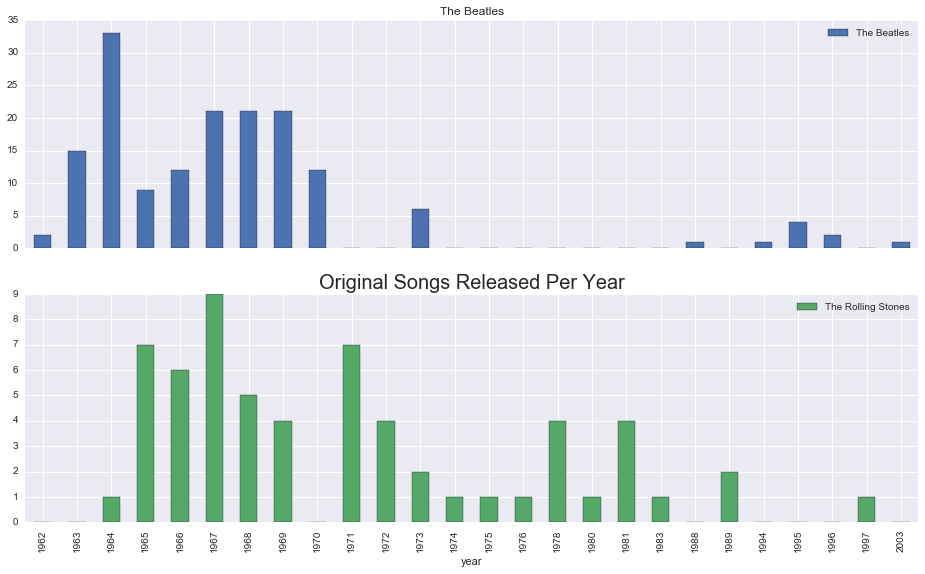

In [166]:
data[data.is_covered > 0].groupby(['artist', 'year']).songname.count().unstack('artist').plot(kind='bar',subplots='True',figsize=(16,9))
plt.title("Original Songs Released Per Year", size=20)

#### The Beatles catalog essentialy ends in 1970 when they disbanded (the outliers are most likely bad release dates in my data). The Rolling Stones continue into this century. However, their eras of influence are 

## Test Logistic Regression Model

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

In [134]:
# Compute Null accuracy
y_null = np.zeros_like(y_test, dtype=float)
# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null
np.sqrt(metrics.mean_squared_error(y_test, y_null))

0.36823482428085047

### Null Accuracy result is *37%*. 
As we will see below, when we fit the Logistic Regression estimator with our data and compute a cross validation score we improve significantly over the null test result.

In [135]:
logreg = LogisticRegression(C=1e9)
#solver='newton-cg',multi_class='multinomial',max_iter=100
logreg.fit(X_train, y_train)
zip(feature_cols, logreg.coef_[0])

[('year', -6.00176939197862e-05),
 ('num_releases', -0.12490383180456067),
 ('lyric_sent', 2.6363935941680432),
 ('title_sent', -1.0990470630763087),
 ('countries', 0.7737027649489393),
 ('avg_rating', -0.021820203303004219)]

In [136]:
print cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()

0.866157916158


In [137]:
y_pred_prob = logreg.predict_proba(X_test)[:,1 ]
print(y_pred_prob).mean()

0.805913171628


#### I am able to predict with 80% probability that a song will be covered.<br><br>

### Compute ROC curve and AUC score.

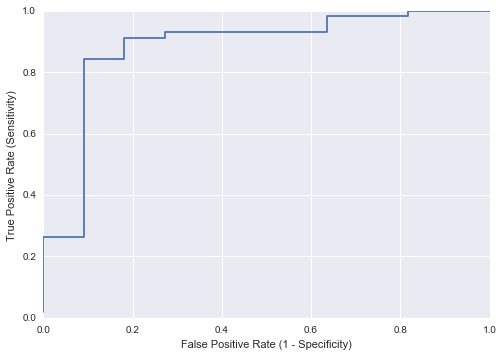

In [138]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [139]:
# calculate AUC
print metrics.roc_auc_score(y_test, y_pred_prob)
print cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.881977671451
0.797994071146


In [ ]:
# TODO: Work on improving accuracy with Random Forest model, TIme Series Analysis 
# and at least one Linear or Logistic Regression Model. Also create some basic bar charts to illustrate some basic assumptions about the data.